In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from tensorboardX import SummaryWriter
import torch

from src import data_prep, dataset, train, visualize
from src.loss import ContrastiveLoss
from src.models import segnet

### Read and process the data

In [6]:
df = data_prep.get_df_from_folder('/home/anuj/code/data/lfw_train')
df_train, df_val = data_prep.split_train_val(df)

In [7]:
np.sum(df_train.groupby('label').count() > 1), np.sum(df_val.groupby('label').count() > 1)

(idx     1356
 path    1356
 dtype: int64, idx     340
 path    340
 dtype: int64)

### Get the dataset and dataloader

In [8]:
%%time
dataset_train, dataloader_train = dataset.get_dataloader(df_train, image_side=160, batch_size=4*24, num_workers=8)
dataset_val, dataloader_val = dataset.get_dataloader(df_val, image_side=160, batch_size=4*24, num_workers=8)

Training: 327,846 total positive pairs 3,416 mini batches
Training: 15,200 total positive pairs 159 mini batches
CPU times: user 12.2 s, sys: 1.68 s, total: 13.8 s
Wall time: 13.8 s


### Visualize

tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.])


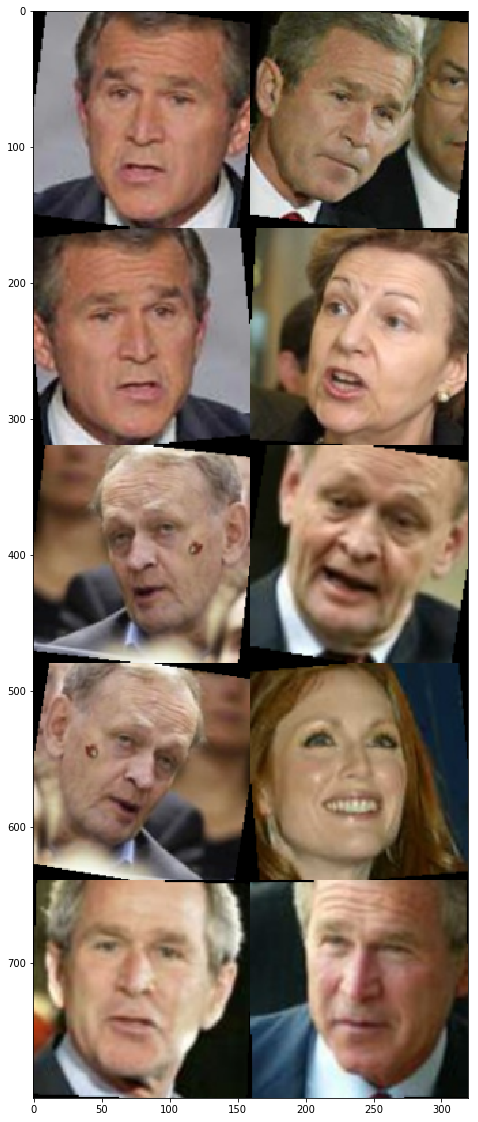

tensor([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.])


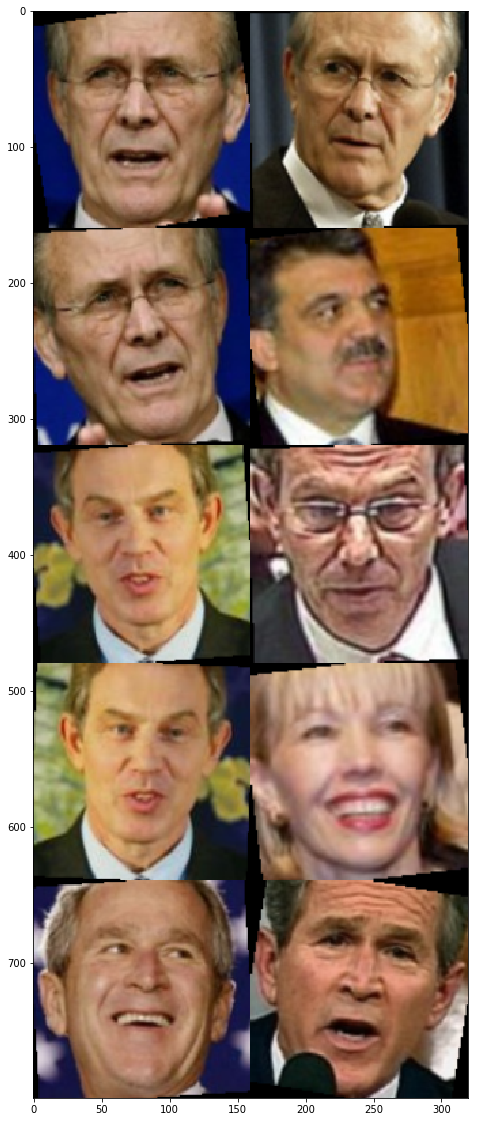

In [10]:
for ix, batch in enumerate(dataloader_val):
    if ix >= 2:
        break
    visualize.visualize(batch, 5)

### Set up model, optimizer, loss function

In [11]:
device_id = 2

In [12]:
# Model, Optimizer, Loss
model = segnet.SiameseNetworkLarge(160)
model = torch.nn.DataParallel(model, device_ids=[2, 3]).cuda(device_id)

optimizer = torch.optim.Adam(model.parameters())
loss_func = ContrastiveLoss().cuda(device_id)

### Set up logging

In [13]:
model_str = 'face-siamese-contrastive-3.04'
weights_folder = f"/home/anuj/weights/{model_str}"
writer = SummaryWriter(weights_folder) # writing log to tensorboard
print('logging to: {}'.format(weights_folder))

logging to: /home/anuj/weights/face-siamese-contrastive-3.04


### Train

In [ ]:
train.run_training_loop(
    model=model,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    loss_func=loss_func,
    optimizer=optimizer,
    writer=writer,
    device=device_id,
    weights_folder=weights_folder,
)